Assign7: RNNs
Due Date: Nov 15, before midnight

We will use the Spoken Arabic Digits dataset. This dataset comprises a training and testing dataset. Each dataset records different utterances of digits from 0 to 9 in Arabic. For each digit, 13 features are measured at each time point, though different digits have different number of time points for each sequence. That is, each person has a τ×13τ×13 sequence for a given digit. Different persons are separated by a blank row in the data files. For a given person, each row is a feature vector of length 13, and the next ττ rows (until the next blank or end of file) represent the sequence for that person.

Also, in the training data the first 660 persons all utter '0', the next 660 utter '1', and so on, until digit '9'. Thus, for each sequence there is only one output label, namely the digit being pronounced.

In the testing data, the format is the same, except each digit has 220 persons, so the first 220 persons utter '0', next 220 utter '1', and so on. See Spoken Arabic Digit Documentation for more details.

Your task is to implement the RNN algorithm 26.1 (on page 679) from scratch in numpy, though you should use the scipy.special.softmax function rather than your own, since it is more robust.

There is one deviation from Algo 26.1. Since there is only one class label per input sequence, there is only one final output from time ττ, as discussed at beginning of lecture 20. Therefore, you should adjust the forward and backwards steps in lines 13, 18, and 19, as required.

You should use cross-entropy loss to predict the digit being spoken. The output layer should use softmax, whereas the hidden layers should use ReLU.

Note that sequences are of different lengths, but is easier to just process them one by one (batch size of one). There is no need to try to pad them to be of the same max length, as long as you only do the forward and backward steps only for the actual sequence length ττ.

Train on the testing set, and report both the training accuracy and average cross-entropy loss, and then finally report the testing accuracy and loss.



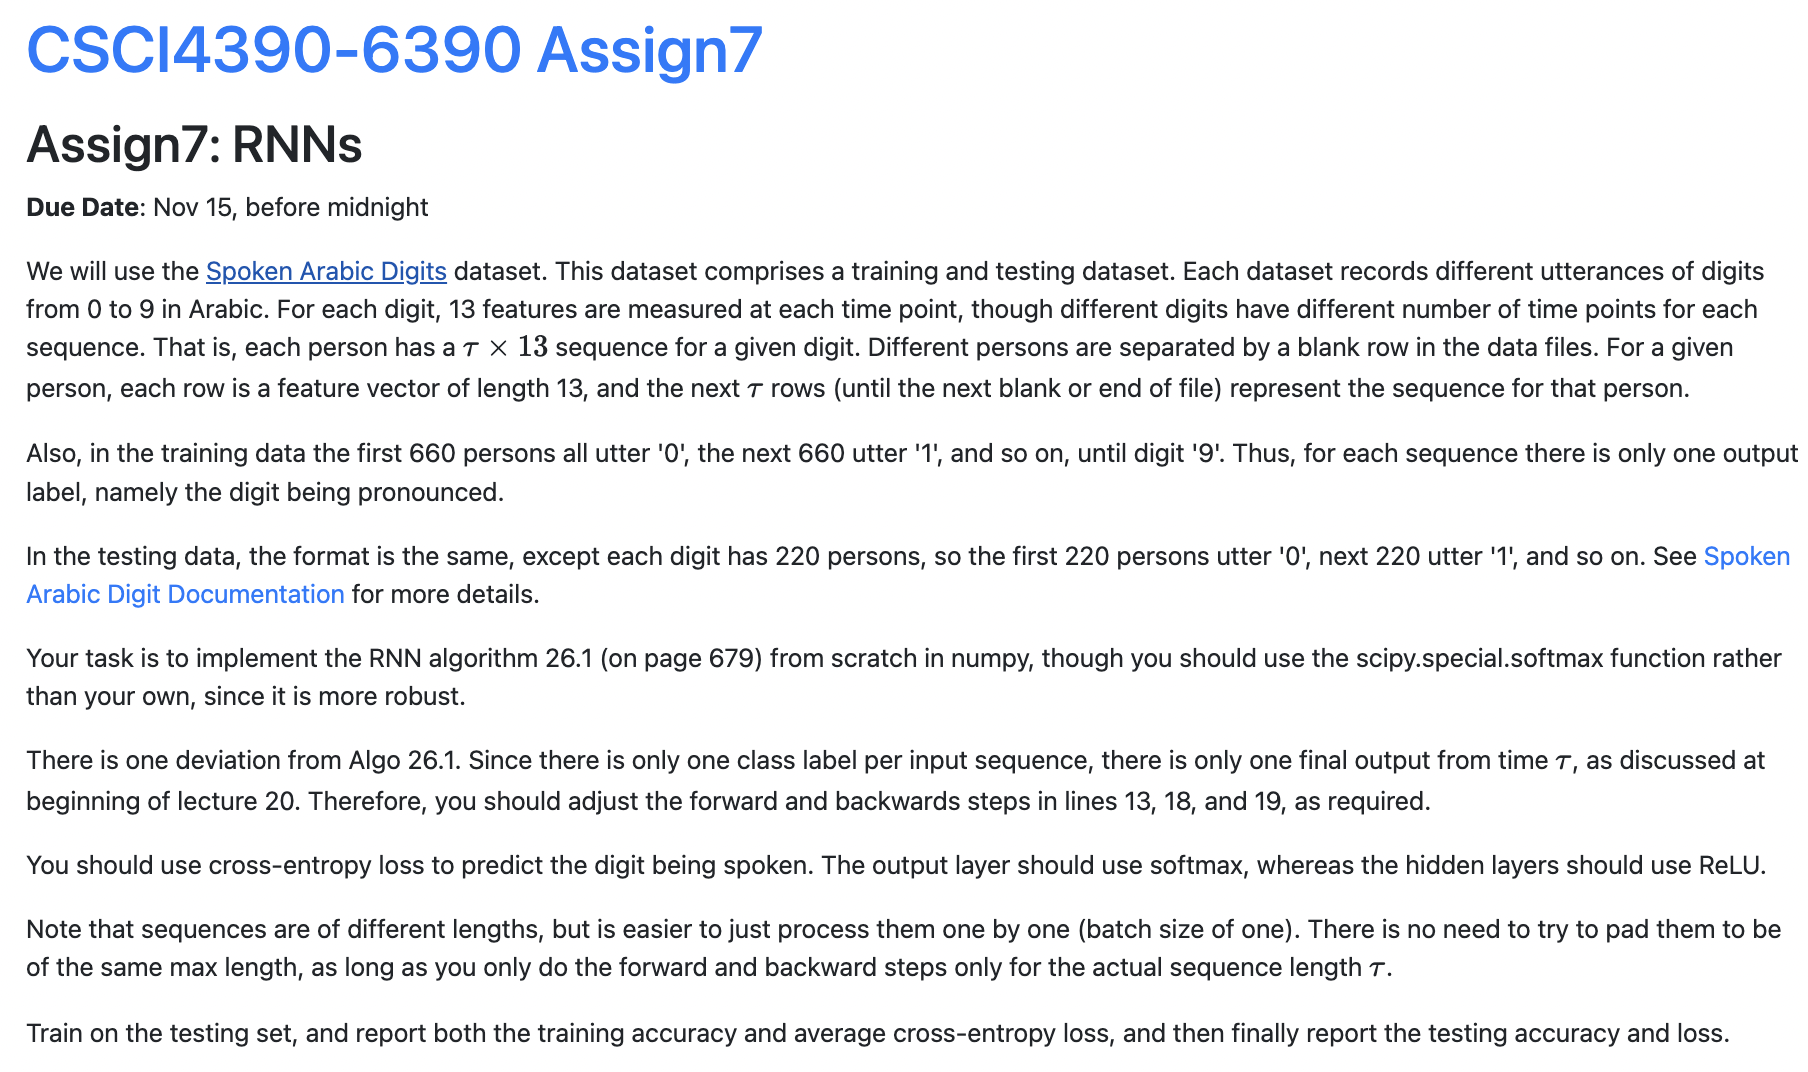

In [46]:
import numpy as np
import pandas as pd
from scipy.special import logsumexp
from scipy.special import softmax
from collections import defaultdict

In [39]:
len_train = 6600
len_test = 2200
classes = 10

def load_data(file, length, classes):
    X = []
    Y = []
    class_size = length/classes
    current_class = 0
    with open(file, 'r') as f:
        row_num = 0
        seq = []
        for i, line in enumerate(f.readlines()):
            row = line.strip().split()
            if len(row) == 0:
                if i > 0:
                    row_num += 1
                    seq = np.array(seq)
                    X.append(np.array(seq))
                    seq = []
                    Y.append(current_class)     
                    if row_num % class_size == 0:
                        current_class += 1
            else:
                x = np.array([float(n) for n in row])
                seq.append(x)
        seq = np.array(seq)
        X.append(seq)
        Y.append(current_class) 
    X = np.array(X)    
    Y = np.array(Y)
    return X, Y

In [43]:
X_train, Y_train = load_data('Train_Arabic_Digit.txt', len_train, classes)
X_test, Y_test = load_data('Test_Arabic_Digit.txt', len_test, classes)

/var/folders/gb/hwvzzncj2f9fs4sfs8f7q2vh0000gn/T/ipykernel_84493/3599465418.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)


In [48]:
Y_train = np.array(pd.get_dummies(Y_train))
Y_test = np.array(pd.get_dummies(Y_test))

In [49]:
Y_train.shape, Y_test.shape

((6600, 10), (2200, 10))

In [55]:
def relu(x):
    return np.maximum(0, x)

In [61]:
class RNN:
    def __init__(self, d, m, p, eta=1e-2):
        self.eta = eta
        self.d = d
        self.m = m
        self.p = p
        self.b_h = np.random.uniform(0, 0.01, (self.m))
        self.b_o = np.random.uniform(0, 0.01, (self.p))
        self.W_i = np.random.uniform(0, 0.01, (self.d, self.m))
        self.W_h = np.random.uniform(0, 0.01, (self.m, self.m))
        self.W_o = np.random.uniform(0, 0.01, (self.m, self.p))

    def feed_forward(self, x):
        self.x = x
        self.tau = self.x.shape[0]
        self.h = np.zeros((self.tau, self.m))
        for i in range(1, self.tau):
            net_ht = np.dot(self.W_i.T,self.x[i]) + np.dot(self.W_h.T, self.h[i-1]) + self.b_h
            self.h[i] = relu(net_ht)
        net_o = np.dot(self.W_o.T,self.h[self.tau-1]) + self.b_o   
        self.o = net_o - logsumexp(net_o)
        return self.o
    
    def backprop(self, y):
        self.del_o = self.o - y
        self.del_h = np.zeros((self.tau, self.m))
        self.del_h[self.tau-1] = relu(self.h[self.tau-1]) * np.dot(self.W_o, self.del_o)
        for i in range(self.tau-2, 0, -1):
            self.del_h[i] = relu(self.h[i]) * np.dot(self.W_h, self.del_h[i+1])
        
        del_b_o = self.del_o
        del_W_o = np.dot(self.h[self.tau-1].reshape(self.m,1), self.del_o.reshape(1,self.p))
        del_b_h = np.zeros(self.m)
        del_W_h = np.zeros((self.m, self.m))
        del_W_i = np.zeros((self.d, self.m))
        for i in range(self.tau):
            del_b_h += self.del_h[i]
            del_W_h += np.dot(self.h[i].reshape(self.m,1), self.del_h[i].reshape(1,self.m))
            del_W_i += np.dot(self.x[i].reshape(self.d,1), self.del_h[i].reshape(1,self.m))
        
        self.b_o = self.b_o - self.eta * del_b_o
        self.b_h = self.b_h - self.eta * del_b_h
        self.W_o = self.W_o - self.eta * del_W_o
        self.W_h = self.W_h - self.eta * del_W_h
        self.W_i = self.W_i - self.eta * del_W_i

In [ ]:
def test_loss_acc(model):
    st = time.time()
    ce_loss = 0
    ncorrect = 0
    n = len(X_test)
    for i in range(n):
        Xi = X_train[i]
        yi = Y_train[i]
        
        oi = model.forward(Xi)
        # ce_loss += np.sum(yi * np.log(oi))
        ce_loss += np.sum(yi * oi)
        mi = np.argmax(oi)  # index of max prob
        if yi[mi] == 1:
            ncorrect += 1

    en = time.time()
    acc = ncorrect/n
    ce_loss /= n
    print(f'test loss:{-1*ce_loss}, acc:{acc}, time:{en-st}')

In [65]:
model = RNN(13, 16, 10, 1e-5)
t = 0
maxiter = 50
while t < maxiter:
    ce = 0
    ncorrect = 0
    n = len(X_train)
    idx = np.arange(n)
    np.random.shuffle(idx)
    for i in idx:
        Xi = X_train[i]
        yi = Y_train[i]
        
        oi = model.feed_forward(Xi) 
        #ce_loss += np.sum(yi * np.log(oi))
        ce += np.sum(yi * oi)
        mi = np.argmax(oi)  # index of max prob
        if yi[mi] == 1:
            ncorrect += 1
        
        model.backprop(yi)
    acc = ncorrect/n
    ce /= n
    print(f'iter:{t} loss:{-1*ce}, acc:{acc}')
    
    t = t + 1
    if t%10 == 0:
        print("\t", end='')
        #test_loss_acc(model)

iter:0 loss:2.3025963863013037, acc:0.1
iter:1 loss:2.302595044433682, acc:0.1
iter:2 loss:2.30259446053514, acc:0.1
iter:3 loss:2.3025937902766764, acc:0.1
iter:4 loss:2.302594888999226, acc:0.0996969696969697
iter:5 loss:2.302594353347831, acc:0.1
iter:6 loss:2.302592663805325, acc:0.10015151515151516
iter:7 loss:2.302593706782959, acc:0.10015151515151516
iter:8 loss:2.302592919981977, acc:0.0996969696969697
iter:9 loss:2.30259248195009, acc:0.08681818181818182
	iter:10 loss:2.3025932234810997, acc:0.0993939393939394
iter:11 loss:2.302592930473396, acc:0.1003030303030303
iter:12 loss:2.3025931417871193, acc:0.0946969696969697
iter:13 loss:2.3025935728801876, acc:0.09833333333333333
iter:14 loss:2.3025941746028242, acc:0.09742424242424243
iter:15 loss:2.3025950231622363, acc:0.09772727272727273
iter:16 loss:2.302599709502469, acc:0.10045454545454545
iter:17 loss:2.302612839850251, acc:0.10303030303030303


/var/folders/gb/hwvzzncj2f9fs4sfs8f7q2vh0000gn/T/ipykernel_84493/3892809340.py:27: RuntimeWarning: overflow encountered in multiply
  self.del_h[self.tau-1] = relu(self.h[self.tau-1]) * np.dot(self.W_o, self.del_o)
/var/folders/gb/hwvzzncj2f9fs4sfs8f7q2vh0000gn/T/ipykernel_84493/3892809340.py:29: RuntimeWarning: invalid value encountered in multiply
  self.del_h[i] = relu(self.h[i]) * np.dot(self.W_h, self.del_h[i+1])
/var/folders/gb/hwvzzncj2f9fs4sfs8f7q2vh0000gn/T/ipykernel_84493/3892809340.py:39: RuntimeWarning: invalid value encountered in add
  del_W_i += np.dot(self.x[i].reshape(self.d,1), self.del_h[i].reshape(1,self.m))


iter:18 loss:nan, acc:0.09636363636363636
iter:19 loss:nan, acc:0.1
	iter:20 loss:nan, acc:0.1
iter:21 loss:nan, acc:0.1
iter:22 loss:nan, acc:0.1
iter:23 loss:nan, acc:0.1
iter:24 loss:nan, acc:0.1
iter:25 loss:nan, acc:0.1
iter:26 loss:nan, acc:0.1
iter:27 loss:nan, acc:0.1
iter:28 loss:nan, acc:0.1
iter:29 loss:nan, acc:0.1
	iter:30 loss:nan, acc:0.1
iter:31 loss:nan, acc:0.1
iter:32 loss:nan, acc:0.1
iter:33 loss:nan, acc:0.1
iter:34 loss:nan, acc:0.1
iter:35 loss:nan, acc:0.1
iter:36 loss:nan, acc:0.1
iter:37 loss:nan, acc:0.1
iter:38 loss:nan, acc:0.1
iter:39 loss:nan, acc:0.1
	iter:40 loss:nan, acc:0.1
iter:41 loss:nan, acc:0.1
iter:42 loss:nan, acc:0.1
iter:43 loss:nan, acc:0.1
iter:44 loss:nan, acc:0.1
iter:45 loss:nan, acc:0.1
iter:46 loss:nan, acc:0.1
iter:47 loss:nan, acc:0.1
iter:48 loss:nan, acc:0.1
iter:49 loss:nan, acc:0.1
	